# Workflow used to fine tune the roBERTa transformer model.

In [2]:
#install required packages
!pip install wandb
!pip install datasets
!pip install seqeval
!pip install sentencepiece
!pip install protobuf==3.20.3

^C


In [42]:
#import packages
import os, re, math, random, json, string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import wandb as wandb
import seqeval as seqeval
from itertools import cycle

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import TrainerCallback, AdamW, get_cosine_schedule_with_warmup
from transformers import DataCollatorForTokenClassification, PreTrainedModel, RobertaTokenizerFast
from sklearn.preprocessing import MultiLabelBinarizer

from datasets import load_dataset, ClassLabel, Sequence, load_metric

from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize

In [43]:
#log in to weights and biases in the command line using: wandb login
wandb.login()
# Copy and paste this API Key when prompted:
#
#cb57f58f2302735dd62e61885e1ab02bce5cfa3f

True

In [44]:
#logging date for w&b
from datetime import date
today = date.today()
log_date = today.strftime("%d-%m-%Y")

## Loading Model

In [45]:
# LOAD OR TRAIN MODEL
TRAIN = 1 # 1 to TRAIN WEIGHTS or 0 to LOAD WEIGHTS

# TRAIN/VALIDATION SPLIT
TRAIN_SPLIT = 0.90

# RANDOM SEED FOR REPRODUCIBILITY
RANDOM_SEED = 42

# BATCH SIZE
# TRY 4, 8, 16, 32, 64, 128, 256. REDUCE IF OOM ERROR, HIGHER FOR TPUS
BATCH_SIZES = 8

# EPOCHS - TRANSFORMERS ARE TYPICALLY FINE-TUNED BETWEEN 1 AND 3 EPOCHS 
EPOCHS = 8

# WHICH PRE-TRAINED TRANSFORMER TO FINE-TUNE?
MODEL_CHECKPOINT = "roberta-base"

# SPECIFY THE WEIGHTS AND BIASES PROJECT NAME
%env WANDB_PROJECT = 'C964v2' 

# DETERMINE WHETHER TO SAVE THE MODEL IN THE 100GB OF FREE W&B STORAGE
%env WANDB_LOG_MODEL = false 

env: WANDB_PROJECT='C964v2'
env: WANDB_LOG_MODEL=false


## Load dataset that was prepared during in the Data_Prep file

In [46]:
FEATURE_CLASS_LABELS = "feature_class_labels.json"
DATA_FILE = 'cuad-v1-annotated.json'
TEMP_MODEL_OUTPUT_DIR = 'temp_model_output_dir'
SAVED_MODEL = f"C964-NER-Fine-Tune-Transformer-{MODEL_CHECKPOINT}"

In [61]:
#create training and validation datasets
data_files = DATA_FILE
datasets = load_dataset('json', data_files=data_files, field='data')
datasets = datasets['train'].train_test_split(test_size=1-TRAIN_SPLIT, seed=RANDOM_SEED)
print(datasets)

Found cached dataset json (C:/Users/adria/.cache/huggingface/datasets/json/default-f9ca68bde6d1a58d/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['split_tokens', 'ner_tags', 'id'],
        num_rows: 289
    })
})


In [48]:
#open the label list created in pre-processing that corresponds to ner_tag indices
with open(FEATURE_CLASS_LABELS, 'r') as f:
    label_list = json.load(f)

for n in range(len(label_list)):
    #display label list
    print(n, label_list[n])

0 B-AGMT_DATE
1 B-DOC_NAME
2 B-EFF_DATE
3 B-PARTY
4 I-AGMT_DATE
5 I-DOC_NAME
6 I-EFF_DATE
7 I-PARTY
8 O


## Tokenize data with the model's tokenizer

In [49]:
#instantiate tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", add_prefix_space=True)

loading file vocab.json from cache at C:\Users\adria/.cache\huggingface\hub\models--roberta-base\snapshots\bc2764f8af2e92b6eb5679868df33e224075ca68\vocab.json
loading file merges.txt from cache at C:\Users\adria/.cache\huggingface\hub\models--roberta-base\snapshots\bc2764f8af2e92b6eb5679868df33e224075ca68\merges.txt
loading file tokenizer.json from cache at C:\Users\adria/.cache\huggingface\hub\models--roberta-base\snapshots\bc2764f8af2e92b6eb5679868df33e224075ca68\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at C:\Users\adria/.cache\huggingface\hub\models--roberta-base\snapshots\bc2764f8af2e92b6eb5679868df33e224075ca68\config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "cl

In [50]:
#function that executes roBERTa tokenizer and aligns the tokens with the labels
def tokenize_and_align_labels(examples, label_all_tokens=False):
    tokenized_inputs = tokenizer(examples["split_tokens"],
                                 truncation=True,
                                 is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            #special tokens have word_idx = set label to -100 to ignore in loss function
            if word_idx is None:
                label_ids.append(-100)
            #set label for first token of each word
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            #for other tokens in a word, set the label to either current label or -100 based on label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [62]:
#use the map method of our dataset object to apply tokenize_and_align_labels to the training and validation sets

tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True, load_from_cache_file=True)

#dataset produces warning when using cached files, pass load_from_cache_file=False to preprocess again

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

## Build roBERTa model

In [63]:
#use AutoModelForTokenClassification class to instantiate the roBERTA base model, specify the num_labels argument

model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=len(label_list))

loading configuration file config.json from cache at C:\Users\adria/.cache\huggingface\hub\models--roberta-base\snapshots\bc2764f8af2e92b6eb5679868df33e224075ca68\config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "rober

In [64]:
#learning rate starts at zero to preserve the pre-trained weights
#Learning rate increases to maximum
#Learning rate reduces using cosine exponential curve to attempt to find global optimal
learning_rate = 0.0000075
lr_max = learning_rate * BATCH_SIZES
weight_decay = 0.05

#optimizer for model
optimizer = AdamW(
    model.parameters(),
    lr=lr_max,
    weight_decay=weight_decay)

#Learning Rate Schedule
num_train_samples = len(datasets["train"])
#percentage of total steps to go from zero to max learning rate
warmup_ratio = 0.2
#Cosine exponential rate
num_cycles=0.8

num_training_steps = num_train_samples*EPOCHS/BATCH_SIZES
num_warmup_steps = num_training_steps*warmup_ratio

lr_sched = get_cosine_schedule_with_warmup(optimizer=optimizer,
                                           num_warmup_steps=num_warmup_steps,
                                           num_training_steps = num_training_steps,
                                           num_cycles=num_cycles)

## Define training arguments

In [65]:
args = TrainingArguments(output_dir = TEMP_MODEL_OUTPUT_DIR,
                         evaluation_strategy = "epoch",
                         learning_rate=lr_max,
                         per_device_train_batch_size=BATCH_SIZES,
                         per_device_eval_batch_size=BATCH_SIZES,
                         num_train_epochs=EPOCHS,
                         weight_decay=weight_decay,
                         lr_scheduler_type = 'cosine',
                         warmup_ratio=warmup_ratio,
                         logging_strategy="epoch",
                         save_strategy="epoch",
                         seed=RANDOM_SEED,
                         report_to = 'wandb', #enable logging to W&B
                         run_name = MODEL_CHECKPOINT+"-"+log_date
                        )

PyTorch: setting up devices


In [55]:
#data collator makes batches samples and makes them all the same size
data_collator = DataCollatorForTokenClassification(tokenizer)

In [66]:
#create function to return precision, recall, f1, and overall model accuracy values
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    #remove special tokens
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)]

    #define the metric parameters
    overall_precision = precision_score(true_labels, true_predictions, zero_division=1)
    overall_recall = recall_score(true_labels, true_predictions, zero_division=1)
    overall_f1 = f1_score(true_labels, true_predictions, zero_division=1)
    overall_accuracy = accuracy_score(true_labels, true_predictions)
    
    #return dictionary of calculated metrics
    return {
        "precision": overall_precision,
        "recall": overall_recall,
        "f1": overall_f1,
        "accuracy": overall_accuracy,}

In [68]:
#define and instantiate Trainer
trainer = Trainer(
                model=model,
                args=args,
                train_dataset=tokenized_datasets["train"],
                eval_dataset=tokenized_datasets["test"],
                data_collator=data_collator,
                tokenizer=tokenizer,
                compute_metrics=compute_metrics,
                optimizers=(optimizer, lr_sched)
                )

In [128]:
#train
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: id, ner_tags, split_tokens. If id, ner_tags, split_tokens are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 198
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 200
  Number of trainable parameters = 124061961
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.385900,0.582801,1.000000,0.000000,0.000000,0.835323
2,0.403200,0.196925,0.649682,0.784615,0.710801,0.932361
3,0.206400,0.158694,0.659639,0.842308,0.739865,0.944960
4,0.138200,0.140770,0.689441,0.853846,0.762887,0.950044
5,0.103800,0.145290,0.730000,0.842308,0.782143,0.950928
6,0.091000,0.143461,0.737374,0.842308,0.786355,0.951813
7,0.088900,0.153956,0.719355,0.857692,0.782456,0.953360
8,0.085100,0.170188,0.749153,0.850000,0.796396,0.954465


The following columns in the evaluation set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: id, ner_tags, split_tokens. If id, ner_tags, split_tokens are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 23
  Batch size = 8
Saving model checkpoint to temp_model_output_dir\checkpoint-25
Configuration saved in temp_model_output_dir\checkpoint-25\config.json
Model weights saved in temp_model_output_dir\checkpoint-25\pytorch_model.bin
tokenizer config file saved in temp_model_output_dir\checkpoint-25\tokenizer_config.json
Special tokens file saved in temp_model_output_dir\checkpoint-25\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: id, ner_tags, split_tokens. If id, ner_tags, split_tokens are not expected by `RobertaForTokenC

TrainOutput(global_step=200, training_loss=0.31281356811523436, metrics={'train_runtime': 79672.5563, 'train_samples_per_second': 0.02, 'train_steps_per_second': 0.003, 'total_flos': 232886285868852.0, 'train_loss': 0.31281356811523436, 'epoch': 8.0})

In [20]:
#finish Weights & Biases logging for run
wandb.finish() 

In [130]:
#save the trained model
trainer.save_model(SAVED_MODEL)

Error in callback <function _WandbInit._resume_backend at 0x000001741406E5F0> (for pre_run_cell):


ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

Saving model checkpoint to C964-NER-Fine-Tune-Transformer-roberta-base
Configuration saved in C964-NER-Fine-Tune-Transformer-roberta-base\config.json
Model weights saved in C964-NER-Fine-Tune-Transformer-roberta-base\pytorch_model.bin
tokenizer config file saved in C964-NER-Fine-Tune-Transformer-roberta-base\tokenizer_config.json
Special tokens file saved in C964-NER-Fine-Tune-Transformer-roberta-base\special_tokens_map.json


Error in callback <function _WandbInit._pause_backend at 0x000001741406E4D0> (for post_run_cell):


ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

In [69]:
#load saved model and instantiate
loaded_model = AutoModelForTokenClassification.from_pretrained(SAVED_MODEL)

pred_trainer = Trainer(
    loaded_model,
    args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

loading configuration file C964-NER-Fine-Tune-Transformer-roberta-base\config.json
Model config RobertaConfig {
  "_name_or_path": "C964-NER-Fine-Tune-Transformer-roberta-base",
  "architectures": [
    "RobertaForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_la

In [70]:
#extract the predictions and labels
predictions, labels, _ = pred_trainer.predict(tokenized_datasets["train"])

The following columns in the test set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: split_tokens, ner_tags, id. If split_tokens, ner_tags, id are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 289
  Batch size = 8


In [71]:
#create classification report
predictions1 = np.argmax(predictions, axis=2)

#remove special tokens
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions1, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions1, labels)
    ]

#generate metrics and print
results = classification_report(true_labels, true_predictions, zero_division=1)
print(results)

              precision    recall  f1-score   support

   AGMT_DATE       0.22      0.80      0.34        86
    DOC_NAME       0.82      0.93      0.87       484
    EFF_DATE       0.17      0.01      0.02       235
       PARTY       0.79      0.88      0.83      2304

   micro avg       0.74      0.82      0.78      3109
   macro avg       0.50      0.66      0.52      3109
weighted avg       0.74      0.82      0.77      3109



In [110]:
# function to plot classification report heat map
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        if(len(t)==0):
            break
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

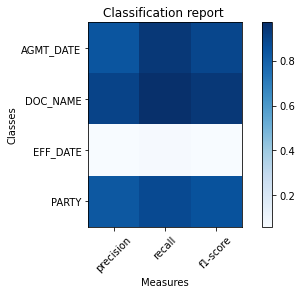

In [111]:
plot_classification_report(results)

In [23]:
#function to get NER tags from array of labels
def getNerTag(arr):
    new = []
    for label in arr:
        for n in label_list:
            if label==n:
                new.append(label_list.index(n))
    return new    

In [24]:
#function to transform 2d label array to 1d
def get1DArray(arr):
    new = []
    for tag_list in arr:
        for tag in tag_list:
            new.append(tag)
    return new

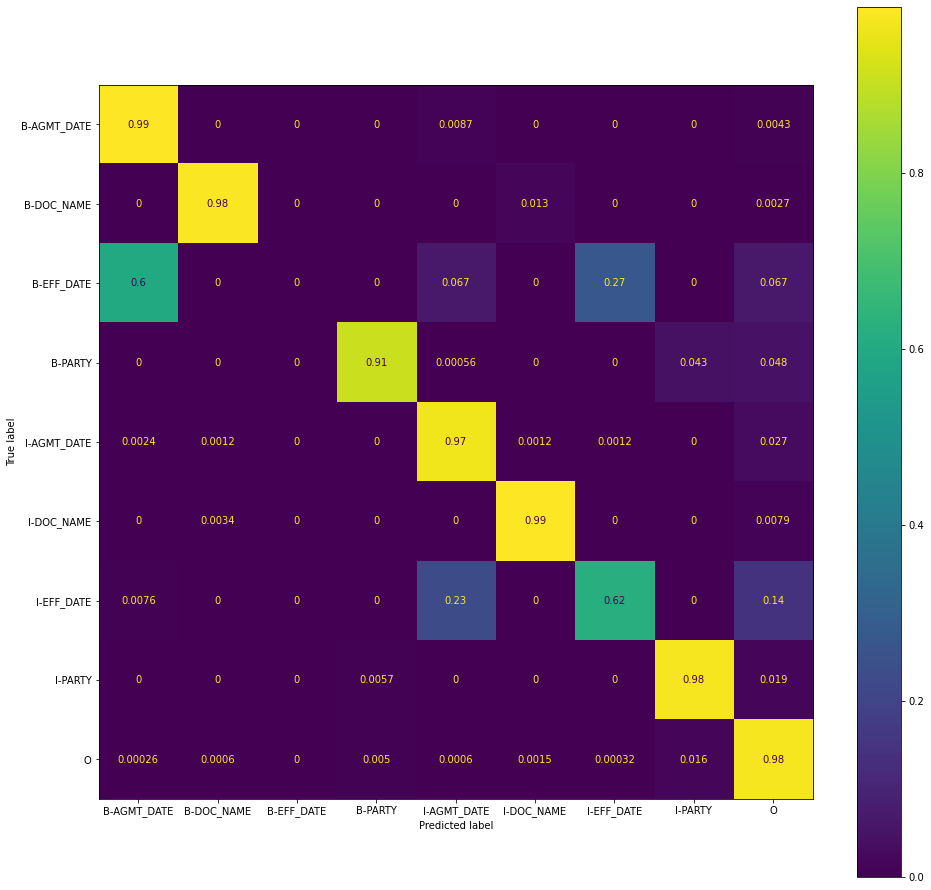

In [107]:
#plot confusion matrix using sklearn
l = getNerTag(get1DArray(true_labels))
p = getNerTag(get1DArray(true_predictions))
conf = confusion_matrix(l, p, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=label_list)
fig, ax = plt.subplots(figsize=(16,16))
disp.plot(ax=ax)